In [30]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
import scipy

from qutip.qip.operations import cnot
from qutip.qip.operations import snot
from qutip.qip.operations import csign

import math

## What has been done as of 2/11 on this document?

Simulated high fidelity CZ gate for two capacitively coupled qutrits

Showed local equivalence of CZ and CNOT via hadamard single qubit gates

Implemented parity ZZZZ, XXXX parity measurements with perfect CNOTs with expected measurement outcomes


## Next:

Two qubit gate dataset (detuning, gamma1, gamma2, small correction to optimal gate time, others, gamma_Tup)

Implement full parity protocol for distance d code (or whatever architecture of interest) and output P_l for ideal and non ideal two qubit gates

Threshold plots P_l ~ two qubit gate fidelity

In [31]:
π = np.pi
µs_to_ns = 1e3

# Two Qutrits, Capacitively Coupled

### States
$|g\rangle=(1,0,0)^T$, $|e\rangle=(0,1,0)^T$, $|f\rangle=(0,0,1)^T$

In [32]:
num_qubit_states = 3

g_state = qt.basis(num_qubit_states, 0)
e_state = qt.basis(num_qubit_states, 1)
f_state = qt.basis(num_qubit_states, 2)

### Creation/Annihilation Operators (q1, q2)
$b_1,b_1^\dagger, b_2, b_2^\dagger$

In [33]:
b1 = qt.tensor(qt.destroy(num_qubit_states), qt.qeye(num_qubit_states))
b1dag = b1.dag() 
b2 = qt.tensor(qt.qeye(num_qubit_states), qt.destroy(num_qubit_states))
b2dag = b2.dag() 

### Projection Operators

In [34]:
gg_proj = qt.tensor(g_state, g_state).proj()
ge_proj = qt.tensor(g_state, e_state).proj()
gf_proj = qt.tensor(g_state, f_state).proj()

eg_proj = qt.tensor(e_state, g_state).proj()
ee_proj = qt.tensor(e_state, e_state).proj()
ef_proj = qt.tensor(e_state, f_state).proj()

fg_proj = qt.tensor(f_state, g_state).proj()
fe_proj = qt.tensor(f_state, e_state).proj()
ff_proj = qt.tensor(f_state, f_state).proj()

### Hamiltonian
$H/\hbar = \sum_{i=1}^2{\left(\omega_i b_i^\dagger b_i + \frac{\alpha_i}{2} b_i^\dagger b_i^\dagger b_i b_i\right)} + J(b_1^\dagger b_2+b_2^\dagger b_1+b_1^\dagger b_2^\dagger+b_1 b_2)$


In [35]:
def hamiltonian(omega_1, omega_2, alpha_1, alpha_2, J_coupling):
    t1 = (omega_1 * b1dag * b1) + (omega_2 * b2dag * b2)
    t2 = (alpha_1 / 2 * b1dag * b1dag * b1 * b1) + (alpha_2 / 2 * b2dag * b2dag * b2 * b2)
    t4 = J_coupling * (b1dag * b2 + b2dag * b1)
    t5 = J_coupling * (b1dag * b2dag + b1 * b2)
    return t1 + t2 + t4 + t5

### Convenient Plotting Function

In [36]:
def plotresult(time_evolution_b):
    gf_pops = qt.expect(gf_proj, time_evolution_b.states)
    fg_pops = qt.expect(fg_proj, time_evolution_b.states)
    ee_pops = qt.expect(ee_proj, time_evolution_b.states)
    
    fig, ax = plt.subplots(tight_layout=True)
    ax.plot(t_vec * µs_to_ns, gf_pops, label="gf")
    ax.plot(t_vec * µs_to_ns, fg_pops, label="fg")
    ax.plot(t_vec * µs_to_ns, ee_pops, label="ee")
    
    ax.legend()
    ax.set_xlabel('Time, $t$ [ns]')
    ax.set_ylabel(r'Amplitude Squared, $P_{mn}$')
    ax.set_title('CZ gate')

    plt.show()
    plt.close()

## Resonance Between $|2,0\rangle, |1,1\rangle$
$\psi_0=|f,g,0\rangle$ 
<br> 
$\omega_{1ef}=\omega_{2ge}$ or in other words $\omega_{1ge}+\alpha_1 = \omega_{2ge}$

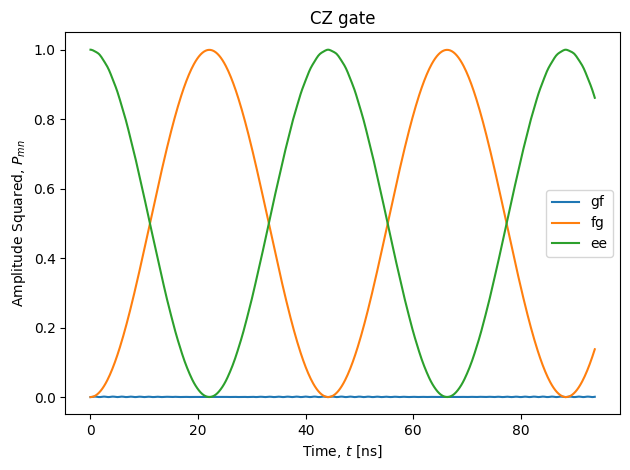

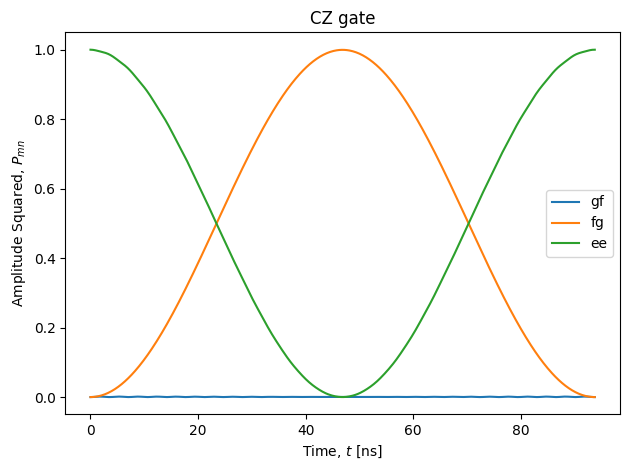

In [37]:
omega1 = 2*π * 6000
alpha1 = 2*π * -300
alpha2 = 2*π * -300
omega2 = omega1 + alpha1
J_coupling = 2*π * 8

t_start = 0
t_end = 3 * π / (2 * J_coupling)
t_vec = np.linspace(t_start, t_end, 601)

h = hamiltonian(omega_1=omega1, omega_2=omega2, alpha_1=alpha1, 
                alpha_2=alpha2, J_coupling=J_coupling)

psi0 = qt.tensor(e_state, e_state)
te0 = qt.mesolve(h, psi0, t_vec, [], [])
_ = plotresult(te0)

ee_pops = qt.expect(ee_proj, te0.states)
#argument of value closest to 1
argmin = np.argmin(np.abs(ee_pops-1)[1:]) + 1
newt_end = t_vec[argmin]
newt_vec = np.linspace(t_start, newt_end, 601)

te1 = qt.mesolve(h, psi0, newt_vec, [], [])
_ = plotresult(te1)

### Propogator

In [38]:
def compute_propogator(h, t_vec): #output propogator matrix
    propogator = qt.propagator(h, t_vec)
    prop = qt.Qobj(np.array(propogator[-1]))
    return prop

propogator = compute_propogator(h, newt_vec)

In [39]:
def unitary(phi_1, phi_2, phi_3):
    return qt.qdiags([
        1,                 # gg
        np.exp(1j*phi_2),  # ge
        1,                 # gf
        np.exp(1j*phi_1),  # eg
        np.exp(1j*phi_3),  # ee
        1,                 # ef
        1,                 # fg
        1,                 # fe
        1                  # ff
    ],
    offsets=0,
    dims=[[3, 3], [3, 3]])

## Begin with basis states: $|gg\rangle |eg\rangle |ge\rangle |ee\rangle $

$U|gg\rangle = |gg\rangle$

$U|eg\rangle = e^{(i\phi_1)}|eg\rangle$

$U|ge\rangle = e^{(i\phi_2)}|ge\rangle$

$U|ee\rangle = e^{(i\phi_1+\phi_2+\phi_c)}|ee\rangle$



In [40]:
psi0 = qt.tensor(g_state, g_state)
te0 = qt.mesolve(h, psi0, newt_vec, [], [])
state0 = te0.states[-1]
#compute angle between final state and initial state (1)
phi_0 = np.angle((psi0.dag() * state0).full()[0][0])
fid_gg = qt.fidelity(unitary(0, 0, 0) * psi0, state0)

psi1 = qt.tensor(e_state, g_state)
te1 = qt.mesolve(h, psi1, newt_vec, [], [])
state1 = te1.states[-1]
#compute angle between final state and initial state (phi_1)
phi_1 = np.angle((psi1.dag() * state1).full()[0][0])
fid_eg = qt.fidelity(unitary(phi_1, 0, 0) * psi1, state1)

psi2 = qt.tensor(g_state, e_state)
te2 = qt.mesolve(h, psi2, newt_vec, [], [])
state2 = te2.states[-1]
#compute angle between final state and initial state (phi_2)
phi_2 = np.angle((psi2.dag() * state2).full()[0][0])
fid_ge = qt.fidelity(unitary(0, phi_2, 0) * psi2, state2)

psi3 = qt.tensor(e_state, e_state)
te3 = qt.mesolve(h, psi3, newt_vec, [], [])
state3 = te3.states[-1]
#compute angle between final state and initial state (phi_3 = phi_1 + phi_2 + phi_c)
phi_3 = np.angle((psi3.dag() * state3).full()[0][0])
fid_ee = qt.fidelity(unitary(0, 0, phi_3) * psi3, state3)

#compare evolved final state with generated unitary as a function of computed angle
#show that U applied to basis states are of the form described above
print(fid_gg, fid_eg, fid_ge, fid_ee)

conditionalphase = phi_3 - phi_2 - phi_1 - phi_0
conditionalphase

0.9999998685848434 0.9991377060211311 0.999138053944885 0.9999816904565442


3.105635860796071

In [41]:
# Define the single-qubit correction gate
def rz(theta):
    return qt.qdiags([
        1,                 # g
        np.exp(1j*theta),  # e
        1,                 # f
    ],
    offsets=0,
    dims=[[3], [3]])

$(R_z(-\phi_1) \otimes R_z(-\phi_2)) * \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & e^{i\phi_1} & 0 & 0 \\
0 & 0 & e^{i\phi_2} & 0 \\
0 & 0 & 0 & e^{i(\phi_1+\phi_2+\phi_c)}
\end{bmatrix}|gg, eg, ge, ee\rangle = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & e^{i\phi_c}
\end{bmatrix}|gg, eg, ge, ee\rangle$



In [42]:
corrected_state_gg = qt.tensor(rz(-phi_1), rz(-phi_2))* state0
corrected_state_eg = qt.tensor(rz(-phi_1), rz(-phi_2))* state1
corrected_state_ge = qt.tensor(rz(-phi_1), rz(-phi_2))* state2
corrected_state_ee = qt.tensor(rz(-phi_1), rz(-phi_2))* state3

fid_gg = qt.fidelity(unitary(0, 0, conditionalphase) * psi0, state0)
fid_eg = qt.fidelity(unitary(0, 0, conditionalphase) * psi1, state1)
fid_ge = qt.fidelity(unitary(0, 0, conditionalphase) * psi2, state2)
fid_ee = qt.fidelity(unitary(0, 0, conditionalphase) * psi3, state3)
print(fid_gg, fid_eg, fid_ge, fid_ee)

0.9999998685848434 0.9991377060211311 0.999138053944885 0.9999816904565442


In [43]:
#What we have
qt.Qobj(qt.tensor(rz(-phi_1), rz(-phi_2)).full().reshape(9,9)) * propogator

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[ 9.99998684e-01+1.52013443e-03j  0.00000000e+00+0.00000000e+00j
   3.45804876e-06-2.60360064e-06j  0.00000000e+00+0.00000000e+00j
  -2.35796551e-04+5.15400948e-04j  0.00000000e+00+0.00000000e+00j
   9.02014906e-07-1.08402047e-06j  0.00000000e+00+0.00000000e+00j
   1.06964717e-08-1.21982967e-06j]
 [ 0.00000000e+00+0.00000000e+00j  9.99138027e-01-4.77158525e-05j
   0.00000000e+00+0.00000000e+00j -3.23358480e-02-2.60273179e-02j
   0.00000000e+00+0.00000000e+00j -9.21657366e-05-4.06583578e-04j
   0.00000000e+00+0.00000000e+00j -5.87412100e-05+1.90446382e-05j
   0.00000000e+00+0.00000000e+00j]
 [ 3.45748038e-06-2.60317270e-06j  0.00000000e+00+0.00000000e+00j
   4.18635646e-01+9.08138724e-01j  0.00000000e+00+0.00000000e+00j
   4.46481566e-03-2.88378934e-03j  0.00000000e+00+0.00000000e+00j
  -6.56022655e-05+3.82270673e-05j  0.00000000e+00+0.00000000e+00j
  -6.55388393e-06+1.59494886e-06j]
 [ 0.0000000

In [44]:
qt.tensor(rz(-phi_1), rz(-phi_2)) * unitary(phi_1, phi_2, phi_3)

Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          1.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          1.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.    

Ideal:
\begin{bmatrix}
    1 & 0 & 0 & 0 \\
    0 & 1 & 0 & 0 \\
    0 & 0 & 1 & 0 \\
    0 & 0 & 0 & -1
\end{bmatrix}

In [45]:
#lindblad operator 1,2; detunings; tao misalignments

In [46]:
#failure rate that is architecture independent? - nahhh

$L_1 = a,   \gamma_1 = 0.1,  \gamma_{\alpha\ge2} = 0$

## Interesting question-- how can the sources of our two qubit gate fidelities be somehow related to R_e error pyramid? - how should we be adequately utilizing the leakage probabilities in our 9x9 propagator?

## CZ and CNOT Locally Equivalent

In [52]:
cz = csign()
cz

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0. -1.]]

In [53]:
qt.tensor(qt.qeye(2), snot()) * cz * qt.tensor(qt.qeye(2), snot())

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]

In [55]:
#states
g_state = qt.basis(num_basis, 0)
e_state = qt.basis(num_basis, 1)

gg = qt.tensor(g_state, g_state)
ge = qt.tensor(g_state, e_state)
eg = qt.tensor(e_state, g_state)
ee = qt.tensor(e_state, e_state)

p_state = (g_state+e_state)/np.sqrt(2)
m_state = (g_state-e_state)/np.sqrt(2)

#operators
CNOT = cnot()
SNOT = snot()
x = qt.sigmax()
y = qt.sigmay()
z = qt.sigmaz()

## Parity Checks
four data qubits, fifth qubit ancilla ALWAYS initialized in g

In [56]:
#Z Parity
jointstate = qt.tensor(e_state, e_state, e_state, e_state, g_state)
ca = cnot(N=5, control=0, target=4)
cb = cnot(N=5, control=1, target=4)
cc = cnot(N=5, control=2, target=4)
cd = cnot(N=5, control=3, target=4)
finalstate = ca*cb*cc*cd*jointstate

#project into original state
proj1 = jointstate.proj() 
#project into original state with flipped qubit 5
proj2 = (qt.tensor(qt.qeye(2), qt.qeye(2), qt.qeye(2), qt.qeye(2), qt.create(2))*jointstate).proj() 

if (qt.expect(proj1, finalstate) == 1):
    print("even parity")
if (qt.expect(proj2, finalstate) == 1):
    print("odd parity")
    
    
#Next Step: noisy CNOT gates- input a fidelity, output a noisy cnot gate of that fidelity (how should do this)
    #1- random correction to the gate defined by some mean and standard deviation
    #2- obtain real data on noisy cnot gates, quantify the mean and standard deviation of that set
    
finalstate.ptrace(4)

even parity


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 0.]]

In [57]:
#X Parity
had = qt.tensor(qt.qeye(2), qt.qeye(2), qt.qeye(2), qt.qeye(2), SNOT)

jointstate = qt.tensor(p_state, p_state, p_state, p_state, g_state)
ca = cnot(N=5, control=4, target=0)
cb = cnot(N=5, control=4, target=1)
cc = cnot(N=5, control=4, target=2)
cd = cnot(N=5, control=4, target=3)


finalstate = had*ca*cb*cc*cd*had*jointstate

#project into original state
proj1 = jointstate.proj() 
#project into original state with flipped qubit 5
proj2 = (qt.tensor(qt.qeye(2), qt.qeye(2), qt.qeye(2), qt.qeye(2), qt.create(2))*jointstate).proj() 

if math.isclose(qt.expect(proj1, finalstate), 1):
    print("even parity")
if math.isclose(qt.expect(proj2, finalstate), 1):
    print("odd parity")
    
finalstate.ptrace(4)

even parity


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 0.]]

In [189]:
corrected_state_ge

Quantum object: dims = [[3, 3], [1, 1]], shape = (9, 1), type = ket
Qobj data =
[[ 0.00000000e+00+0.00000000e+00j]
 [ 9.79517349e-02+9.95159629e-01j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 7.53200262e-03-2.08455585e-03j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-1.06281267e-03-7.50699683e-04j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-5.76974165e-07+1.65959908e-05j]
 [ 0.00000000e+00+0.00000000e+00j]]

In [162]:
state0

Quantum object: dims = [[3, 3], [1, 1]], shape = (9, 1), type = ket
Qobj data =
[[ 9.99999731e-01+5.81756964e-06j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 8.25167185e-06-1.60823259e-06j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-3.94602284e-04+6.17827469e-04j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 7.12992158e-06-4.00007983e-06j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-4.18786187e-07-7.49521398e-07j]]

In [127]:
t_start = 0
t_end = 3 * π / (2 * J_coupling)
t_vec = np.linspace(t_start, t_end, 601)

psi0 = qt.tensor(e_state, e_state)

delta_vec = 2*π * np.linspace(-50, 50, 51)
ee_pops = np.zeros(delta_vec.shape + t_vec.shape)

for idx, detuning in enumerate(delta_vec):
    h = hamiltonian(omega_1=omega1, omega_2=omega2-detuning, alpha_1=alpha1, 
                    alpha_2=alpha2, J_coupling=J_coupling)
    time_evolution = qt.mesolve(h, psi0, t_vec, [], [])
    
    argmin = np.argmin(np.abs(ee_pops-1)[1:]) + 1
    
    
    newt_end = t_vec[argmin]
    newt_vec = np.linspace(t_start, newt_end, 601)
    
    ee_pops[idx,:] = qt.expect(ee_proj, time_evolution.states)

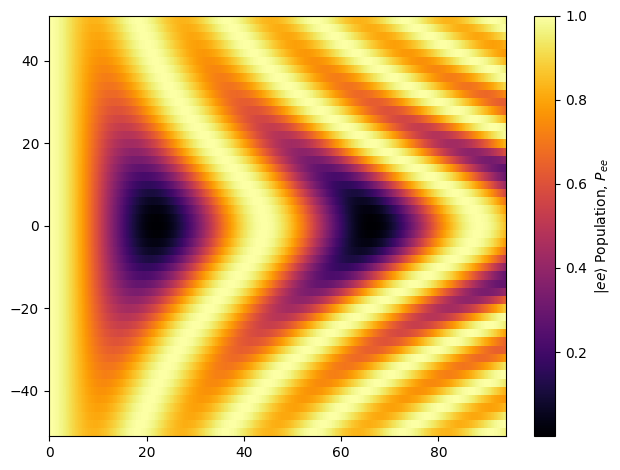

In [128]:
fig, ax = plt.subplots(tight_layout=True)
mesh = ax.pcolormesh(
    t_vec * µs_to_ns,
    delta_vec / (2*π),
    ee_pops,
    cmap="inferno",
)
fig.colorbar(
    mesh,
    label=r"$\vert ee \rangle$ Population, $P_{ee}$"
)

In [68]:
psi0 = qt.tensor(g_state, g_state)
te1 = qt.mesolve(h, psi0, newt_vec, [], [])
state = te1.states[-1]
phi = np.angle((psi0.dag() * state).full()[0][0]) #get ee amp and find the complex phase
phi

0.0015200907937738838

In [69]:
psi0 = qt.tensor(g_state, e_state)
te1 = qt.mesolve(h, psi0, newt_vec, [], [])
state = te1.states[-1]
phi = np.angle((psi0.dag() * state).full()[0][0]) #get ee amp and find the complex phase
phi

-0.23282420185474872

In [70]:
psi0 = qt.tensor(e_state, g_state)
te1 = qt.mesolve(h, psi0, newt_vec, [], [])
state = te1.states[-1]
phi = np.angle((psi0.dag() * state).full()[0][0]) #get ee amp and find the complex phase
phi

-2.018874026558969

In [71]:
psi0 = qt.tensor(e_state, e_state)
te1 = qt.mesolve(h, psi0, newt_vec, [], [])
state = te1.states[-1]
phi = np.angle((psi0.dag() * state).full()[0][0]) #get ee amp and find the complex phase
phi

0.8554577231761269

In [66]:
np.angle(np.exp((1j)*π))

3.141592653589793

In [67]:
te1.states[-1]

Quantum object: dims = [[3, 3], [1, 1]], shape = (9, 1), type = ket
Qobj data =
[[-2.35964334e-04+5.15106643e-04j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 4.46590719e-03-2.89036351e-03j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 6.55861048e-01+7.54857382e-01j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 9.87472255e-04-8.62074110e-04j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-5.31347790e-04-2.44920512e-03j]]

In [35]:
def compute_propogator(h, t_vec): #output propogator matrix
    propogator = qt.propagator(h, t_vec)
    prop = qt.Qobj(np.array(propogator[-1]))
    return prop

propogator = compute_propogator(h, newt_vec)
propogator

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[ 9.99998684e-01+1.52013443e-03j  0.00000000e+00+0.00000000e+00j
   3.45804876e-06-2.60360064e-06j  0.00000000e+00+0.00000000e+00j
  -2.35796551e-04+5.15400948e-04j  0.00000000e+00+0.00000000e+00j
   9.02014906e-07-1.08402047e-06j  0.00000000e+00+0.00000000e+00j
   1.06964717e-08-1.21982967e-06j]
 [ 0.00000000e+00+0.00000000e+00j  9.72168933e-01-2.30573990e-01j
   0.00000000e+00+0.00000000e+00j -3.74685739e-02-1.78643308e-02j
   0.00000000e+00+0.00000000e+00j -1.83488563e-04-3.74348335e-04j
   0.00000000e+00+0.00000000e+00j -5.27621918e-05+3.20839387e-05j
   0.00000000e+00+0.00000000e+00j]
 [ 3.45748038e-06-2.60317270e-06j  0.00000000e+00+0.00000000e+00j
   4.18635646e-01+9.08138724e-01j  0.00000000e+00+0.00000000e+00j
   4.46481566e-03-2.88378934e-03j  0.00000000e+00+0.00000000e+00j
  -6.56022655e-05+3.82270673e-05j  0.00000000e+00+0.00000000e+00j
  -6.55388393e-06+1.59494886e-06j]
 [ 0.0000000

In [22]:
def unitary(phi_1, phi_2, phi_3):
    return (
        qt.tensor(g_state, g_state).proj() * 1 +
        qt.tensor(g_state, e_state).proj() * np.exp(1j*phi_2) +
        qt.tensor(g_state, f_state).proj() * 1 +
        qt.tensor(e_state, g_state).proj() * np.exp(1j*phi_1) +
        qt.tensor(e_state, e_state).proj() * np.exp(1j*phi_3) +
        qt.tensor(e_state, f_state).proj() * 1 +
        qt.tensor(f_state, g_state).proj() * 1 +
        qt.tensor(f_state, e_state).proj() * 1 +
        qt.tensor(f_state, f_state).proj() * 1
    )

In [24]:
unit = qt.Qobj(np.array(unitary(0, 0, π)).reshape(9,9))

In [25]:
qt.process_fidelity(unit, propogator)

(0.10078914721666707-0.0693667113684025j)

Text(0.5, 1.0, 'Energy Levels')

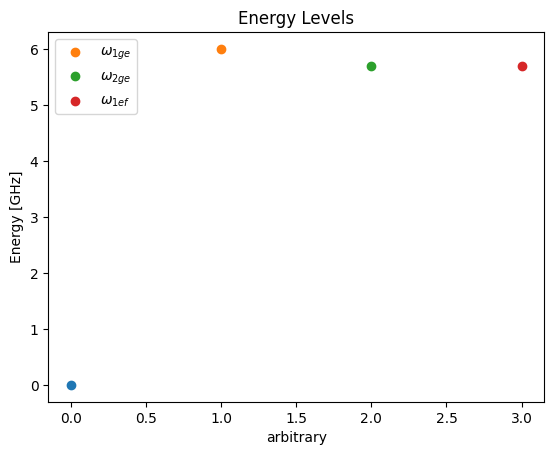

In [26]:
fig = plt.figure()
plt.scatter(0,0)
plt.scatter(1, omega1/(1000*2*π), label='$\omega_{1ge}$')
plt.scatter(2, omega2/(1000*2*π), label='$\omega_{2ge}$')
plt.scatter(3, (omega1+alpha1)/(1000*2*π), label='$\omega_{1ef}$')
plt.legend()
plt.ylabel('Energy [GHz]')
plt.xlabel('arbitrary')
plt.title('Energy Levels')

Next steps: varied detunings, initial state - final state find those fidelities, try to somehow generate the exact Cz gate so that it can be directly translated to CNOTS in threshold theorem parity measurements ==> realistic set of errors that generate gate infidelity